# sc_filter_interp
WakenAI switched-cap filter model based on numpy and using interpolation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sc_filter_interp as sfi

___
## Quickstart

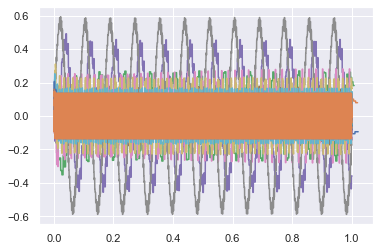

In [2]:
# test signal
fs = 16000.
fsig = 310.
t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(310.)*t_vec)

# initilaize filter for this sample rate and with (32-channel) default center frequencies and bandwidths
scfilter = sfi.SCFilter(fs, len(t_vec), fc=sfi.CHIP_DFLT_FC, fbw=sfi.CHIP_DFLT_FBW)
output, t_vec_out = scfilter(signal)

plt.figure()
[plt.plot(t, out) for t, out in zip(t_vec_out, output)]
plt.show()

---
## Theory

This code models a bank of demodulated bandpass filters specified by their center frequencies (fc) and bandwidths (fbw). We can approximate a given channel as shown in the block diagram below.

<!---
![Approximate model for a singel channel.](demo_files/approx_channel.svg)
-->
<div style="text-align:center"><img src="demo_files/approx_channel.svg" width="700"></div>  

  
Effectively, a signal is bandpass filtered and then demodulated (multiplied by a cos), where the demodulation shifts the filtered chunk of spectra centered at fc, down to 0 Hz (i.e., baseband). In reality, the signal is not multiplied by a perfect sine wave, thus aliases end up in other filter channel outputs. The center frequency and bandwidth are related by fbw = 3*fc/(np.pi*4*k), where k is a programmable chip hardware parameter for each channel. In the demo chip, k is an integer between 2 to 8. However, for simulation pruposes any this code allows non-integer k, and thus arbitrary fbw.

As an example, create a single tone at 310 Hz, sampled at 16 kHz:

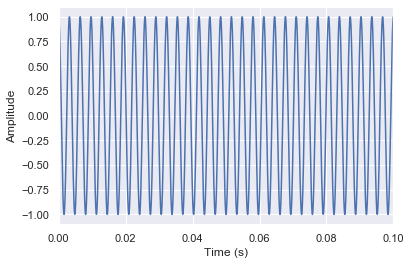

In [7]:
# tone
fs = 16000.
fsig = 310.

t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(fsig)*t_vec)

plt.figure()
plt.plot(t_vec, signal)
plt.xlim((0, 0.1))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Now, initialize an SCFilter bank with a single channel, centered at 300 Hz, and a bandwidth of 20 Hz. 

In [4]:
fc = np.array([300.])
fbw = np.array([20.])

scfilter = sfi.SCFilter(fs, len(signal), fc=fc, fbw=fbw)

Filter the signal and plot the output.

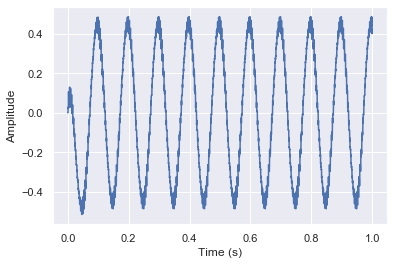

In [8]:
output, t_vec_out = scfilter(signal)

# output and corresponding time vector come output as array of arrays
plt.figure()
plt.plot(t_vec_out[0], output[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

The output is a 10 Hz tone because the bandpass filter was centered at 300 Hz, and the 310 Hz signal was filtered and downconverted to 310 Hz - 300 Hz = 10 Hz. Note that the signal is attenuated by a little more than 1/2 and there is still some high frequency content present due to non-idealities of the filter and downconversion.

What would happen if the input signal was a tone of 300 Hz - the same as the center frequency of the filter?

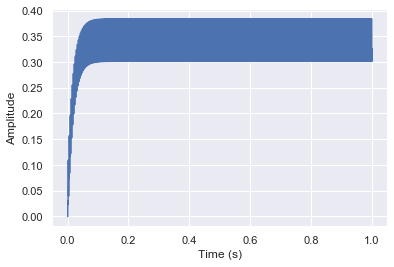

In [9]:
signal = np.cos(2*np.pi*(300.)*t_vec)

output, t_vec_out = scfilter(signal)

plt.figure()
plt.plot(t_vec_out[0], output[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

The output signal is "DC" - a 0 Hz tone, since 300 Hz - 300 Hz = 0 Hz. There is high frequency content, but the average value is 0 Hz. Note that the output also ramps up to the value. This is due to the causality of the filter and the assumption that the signal before time t = 0, is 0.

Recall that we because the demodulation is not perfect, signal content can end up in other filter channels. Consider the case where we have two filter channels: A 300 Hz channel, and a subharmonic, 300 Hz / 3 = 100 Hz.  

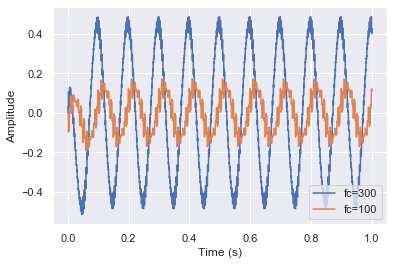

In [19]:
fs = 16000.
fsig = 310.

t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(fsig)*t_vec)

fc = np.array([300., 100.])
fbw = np.array([20., 20.])

scfilter = sfi.SCFilter(fs, len(signal), fc=fc, fbw=fbw)

output, t_vec_out = scfilter(signal)

plt.figure()
plt.plot(t_vec_out[0], output[0])
plt.plot(t_vec_out[1], output[1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(("fc = 300", "fc = 100"))
plt.show()

In this case, we see that a smaller componenent of the 10 Hz tone still appears at the output of this channel.

Using the WakenAI chip default center frequencies and bandwidths (32 channels), and the 310 Hz tone, we see the following output

Chip default channel center frequencies:
[  29.51388889   49.18981481   80.49242424  118.05555556  160.98484848
  196.75925926  265.625       321.96969697  379.46428571  429.29292929
  531.25        643.93939394  708.33333333  787.03703704  965.90909091
 1062.5        1287.87878788 1416.66666667 1574.07407407 1770.83333333
 2125.         2361.11111111 2656.25       3035.71428571 3541.66666667
 3863.63636364 4250.         4722.22222222 5312.5        6071.42857143
 7083.33333333 8500.        ] 

Chip default channel bandwidths:
[2.25469503e+02 3.75782504e+02 6.14916826e+02 1.35281702e+03
 1.84475048e+03 3.00626004e+03 4.05845105e+03 6.14916826e+03
 7.24723402e+03 9.83866921e+03 1.21753531e+04 1.47580038e+04
 1.62338042e+04 2.10438203e+04 2.58265067e+04 2.84091573e+04
 3.44353422e+04 3.78788765e+04 4.20876405e+04 5.41126807e+04
 6.49352168e+04 7.21502409e+04 8.11690210e+04 9.27645954e+04
 1.08225361e+05 1.18064031e+05 1.29870434e+05 1.44300482e+05
 1.62338042e+05 1.85529191e+05 2.16450723

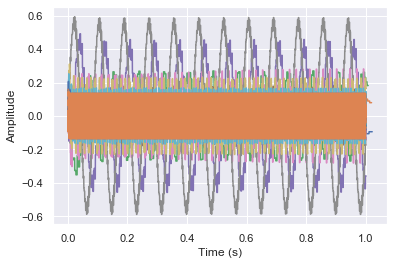

In [21]:
scfilter = sfi.SCFilter(fs, len(t_vec), fc=sfi.CHIP_DFLT_FC, fbw=sfi.CHIP_DFLT_FBW)
output, t_vec_out = scfilter(signal)

print('Chip default channel center frequencies:')
print(sfi.CHIP_DFLT_FC, '\n')
print('Chip default channel bandwidths:')
print(sfi.CHIP_DFLT_FBW, '\n')

plt.figure()
[plt.plot(t, out) for t, out in zip(t_vec_out, output)]
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()